# 1D Double Well Potential

*Note: This is the second of a series of three jupyter notebooks. Generic explanations are given along with the code; however, for a more thorough explanation of the techniques used please visit the first notebook (linked next). The first and third notebooks can be found at this [GitHub repository](https://github.com/javier-rozalen/AJP-Article).*

Here we solve the Double Well (DW) Potential in 1D for a single particle using the NQS method. The Hamiltonian reads, in HO units:

$$\hat{H}=-\frac{1}{2}\frac{d²}{dx²}+\frac{1}{2}(|\hat{x}|-b)^2,$$

where $m$ is the mass of the particle and $w$ is the angular frequency of the oscillator. 

## Imports
We start our code by importing the necessary modules.

In [1]:
# Imports
%matplotlib notebook
import torch, time
from torch import nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

## General parameters

We define the various parameters and hyperparameters.

In [2]:
# Hardware (CPU or GPU)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 8  # Nodes in the hidden layer

# Network parameters.
seed = 1
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

# Training hyperparameters
epochs = 3000
lr = 2e-2  # Learning rate

# Mesh parameters
Nx = 100                    # Mesh division
train_a = -8                     # Mesh lower limit
train_b = 8                        # Mesh upper limit
h = (train_b - train_a) / (Nx - 1)  # Mesh parameter "h"
grid = h*(np.arange(Nx)-Nx/2.+1)
Q_train = torch.from_numpy(grid).requires_grad_().to(device).type(torch.float32)
wi = torch.empty(Nx, 1).fill_(h)
b = 1.5

## Obtaining the benchmark functions

In the notebook [Notebook: 1D Harmonic Oscillator](https://github.com/javier-rozalen/AJP-Article/blob/54ea0908b30eb471962e6d6d809d563211f83cd2/notebook1_JRS.ipynb) the solution to the problem was analytical, i.e., we had a closed-form expression for the wave function of all bound states. This time, however, the quartic term in the Hamiltonian prevents us from finding an exact solution, and we have to use computational tools. 

The idea is to obtain all Hamiltonian matrix elements $H_{ij}=\langle x_i|\hat{H}|x_j\rangle$ and then diagonalize the resulting matrix numerically. The potential part of $H_{ij}$ is straightforward, for the potential is already diagonal in the position space grid. As for the kinetic part, it can be easily obtained by working in the momentum representation [ref appearing in Joan's TFM]. The final expression for the matrix elements can be written as:

$$ H_{ij}=V(x_i)\delta_{ij}+\frac{1}{N_x}\sum_{l=-N_x/2}^{N_x/2}T_l e^{(il2\pi(i-j)/N)}, $$

where $T_l=\frac{2}{m}\big(\frac{\hbar\pi l}{N_x h}\big)^2$. The following code cell implements this formula and diagonalizes the matrix using the numpy library.

<IPython.core.display.Javascript object>


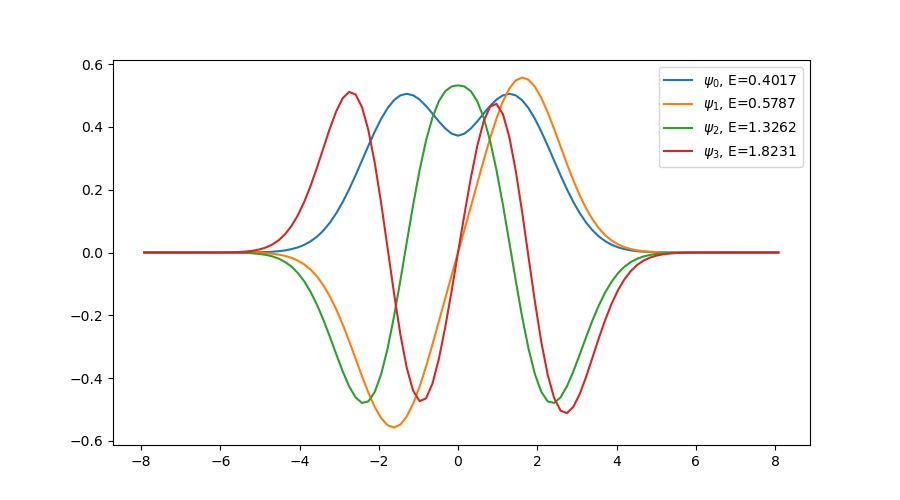

In [3]:
%matplotlib notebook
# We define useful functions
l_indices = [l for l in range(-int(Nx/2), int(Nx/2) + 1)]
V = lambda x : 0.5*(abs(x)-b)**2
delta = lambda i, j : 1 if i == j else 0
pi = np.pi
T = lambda l : 2.*(l*pi/(Nx*h))**2
zi = complex(0., 1.) # imaginary unit

# We construct the Hamiltonian matrix elements
H = np.zeros((Nx, Nx))
for i, xi in enumerate(grid):
    for j, xj in enumerate(grid):
        list_ = [T(l)*np.exp(zi*l*2.*pi*(i-j)/Nx) for l in l_indices]
        H[i][j] = (1/Nx)*np.real(np.sum(list_)) + V(xi)*delta(i, j)
        
# We diagonalize H and obtain the ground-state eigenvalue and eigenvector
eivals, eivecs = np.linalg.eigh(H)

# We sort the eigenvalues and eigenvectors
isort = np.argsort(eivals)
eivals = eivals[isort]
eivecs = eivecs[isort]

ieig = 0
neig = 4
indx_origin = int(Nx/2 - 1)
wf = np.zeros((Nx, neig))

# We order the wavefunction values by setting the correct origin
while ieig < neig :
    # wavefunction at the origin
    wf_at_origin = eivecs[indx_origin,ieig]
    sss = eivecs[indx_origin+2,ieig]
    sss = sss/np.abs(sss)
    wf[:,ieig] = sss*eivecs[:,ieig]/np.sqrt(h);
    ieig = ieig+1

E0_th, psi0_th = eivals[0], wf[:,0]/np.sqrt(h*np.sum(wf[:,0]**2))
E1_th, psi1_th = eivals[1], wf[:,1]/np.sqrt(h*np.sum(wf[:,1]**2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
for i in range(neig):
    ax.plot(grid, wf[:, i], label=f'$\psi_{i}$, E=' + format(eivals[i], '.4f'))
ax.legend()
fig.canvas.draw()
time.sleep(0.01)

## The neural network

We now create the neural network. The architecture is the same as that used for the HO, and therefore so is the code implementation.

In [4]:
class HarmonicNQS(nn.Module):
    def __init__(self, W1, B, W2):
        super(HarmonicNQS, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=False)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o
    
net = HarmonicNQS(W1, B, W2).to(device)

## The optimizer

As in the first notebook, we use RMSprop as our optimizer. We can define our RMSprop optimizer in a single line of code:

In [5]:
optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

## The loss function

The loss function is computed in much the same fashion as for the HO case, this is,

$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}}{\bra{\psi_\theta}\psi_\theta\rangle}. $$

The only difference now is the potential term. Taking this into account, we can write our approximation to the integrals as:

$$ \bra{\psi_\theta}\hat{H}\ket{\psi_\theta}\approx \frac{1}{2}\sum_{i=1}^{N_x} w_i \bigg[\bigg(\frac{d\psi_\theta(x_i)}{dx}\bigg)^2+(|x|-b)^2\psi_\theta^2(x_i)\bigg], $$

$$\bra{\psi_\theta}\psi_\theta\rangle\approx \sum_{i=1}^{N_x} w_i \psi_\theta^2(x_i)\equiv N.$$

The code implementation is, then:

In [6]:
def loss_fn():  
    psi = net(X)
    psi2 = net(X_det).pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = torch.tensordot(psi2, wi)                       
    U =  (1/2) * torch.tensordot((torch.abs(X_det)-b).pow(2) * psi2, wi) / N # Potential energy
    K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
    E = U + K # Total energy
    
    return E, U, K, psi, psi / torch.sqrt(N) 

## Plotting

We set the function that does the plots periodically. Please note that the syntax is slightly more intricate than strictly necessary; this is intended to improve the final visualization of the plots in a jupyter notebook environment.

In [7]:
def pic(i, x, target, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title('Normalized wavefunction')
    wf = psi_normalized.detach().numpy()
    ax1.set_ylim(np.min(wf), np.max(wf)*1.1)
    #if np.max(wf) < 0: wf = -wf
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(grid)
        ax1.lines[1].set_ydata(target)
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NN}$', color='b')
        ax1.plot(grid, target, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend()
    
    
    # Wave function
    ax2.set_title('NQS wavefunction')
    wf = psi.detach().numpy()
    maxwf = np.max(wf)
    if maxwf < 0: wf = -wf 
    ax2.set_ylim(-0.05, maxwf*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)*E0_th][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)*E0_th, linestyle='--', label='$E_0$', color='b')
        #ax3.plot(x, np.ones(i+1)-0.75, linestyle='--', label='$U_0, K_0$', color='g')
        ax3.legend()
        
    fig.canvas.draw()

## Training the network: ground state, $\ket{\psi_0}$

The training is carried out in the exact same manner as for the HO. Below is the code implementation.

<IPython.core.display.Javascript object>


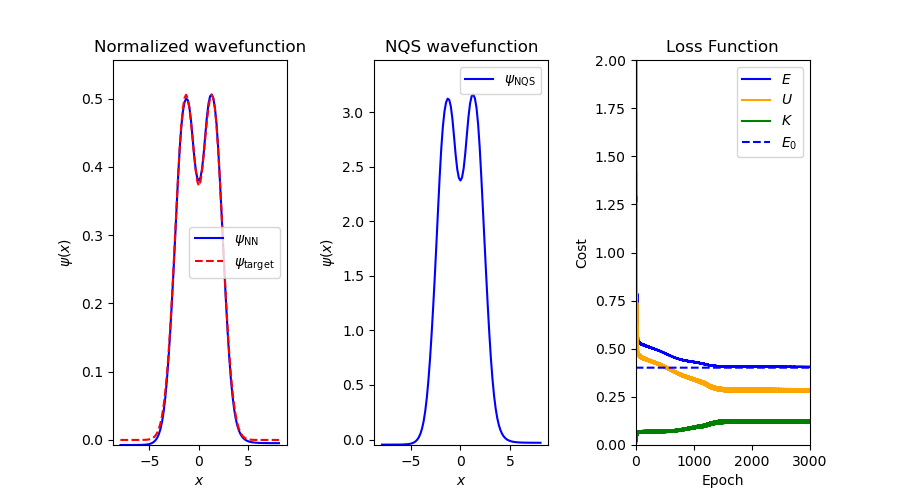

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 537.31it/s]


In [8]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
ax3.set_ylim(0, 2)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)
X_det = X.clone().detach()
target = psi0_th

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation

    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss0.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters

    loss_accum.append(loss0.item())
    U_accum.append(U.item())
    K_accum.append(K.item())

    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)

E0, psi0 = loss_accum[-1], psi.clone().detach()

*Note: When running the above cell more than once, please take into account that the network is already trained from the first run. To restart the training from scratch, first re-run the code cells of sections [General parameters](#General-parameters), [The neural network](#The-neural-network) and [The optimizer](#The-optimizer).*

## Training the network: first excited state, $\ket{\psi_1}$

We now go for the first excited state. As explained in the main article and in the HO notebook [include link], we want to make $\psi_1$ antisymmetric (given that $\psi_0$ is symmetric),

$$ \psi_{1,\theta'}(x) \longleftarrow \psi_{1,\theta'}(x)-\psi_{1,\theta'}(-x) .$$

In [9]:
def loss_fn_prime():  
    psi = net1(X)-net1(-X)    
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = torch.tensordot(psi2, wi)                       
    U =  (1/2) * torch.tensordot((torch.abs(X_det)-b).pow(2) * psi2, wi) / N # Potential energy
    K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
    E = U + K # Total energy
    
    return E, U, K, psi, psi / torch.sqrt(N) 

Now we define a new neural network, which has the exact same architecture as the one used for the ground state. We can do this by creating a new instance of our [previous NQS](#The-neural-network). We also reset the optimizer parameters by redefining it. 

In [10]:
# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 8  # Nodes in the hidden layer

# Network parameters.
seed = 1
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

net1 = HarmonicNQS(W1, B, W2).to(device)
optimizer = torch.optim.RMSprop(params=net1.parameters(), lr=lr)

We define a new plotting function,

In [11]:
def pic(i, x, target, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    # Overlap
    ax1.set_title('Normalized wavefunction')
    wf = psi_normalized.detach().numpy()
    maxwf = np.max(wf)
    ax1.set_ylim(np.min(wf)*1.1, maxwf*1.1)
    if net1(torch.tensor([[-2.]])).item() > 0.: wf *= -1
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(grid)
        ax1.lines[1].set_ydata(target)
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(grid, target, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend()
    
    
    # Wave function
    ax2.set_title('NQS wavefunction')
    wf = psi.detach().numpy()
    maxwf = np.max(wf)
    if maxwf < 0: wf = -wf 
    ax2.set_ylim(np.min(wf)*1.1, maxwf*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x.detach().numpy())
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x.detach().numpy(), wf, 
                 label='$\psi_\mathrm{NQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)*E1_th][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)*E1_th, linestyle='--', label='$E_1$', color='b')
        ax3.legend()
        
    fig.canvas.draw()

Now we are ready to train our ansatz $\psi_{\theta',1}=\langle x | \psi_{\theta',1}\rangle$.

<IPython.core.display.Javascript object>


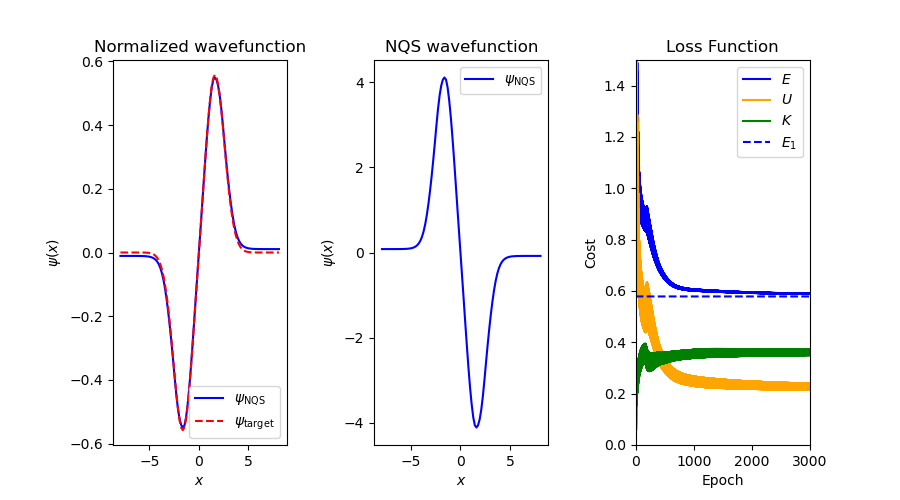

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 495.49it/s]


In [12]:
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")

# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
ax3.set_ylim(0, 1.5)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)
target = psi1_th

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss1, U, K, psi, psi_normalized = loss_fn_prime()    # Energy and \psi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss1.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss_accum.append(loss1.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): # We plot periodically
        pic(i, Q_train, target, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)
        
E1, psi1 = loss_accum[-1], psi

## Extra: Computation Graph

Using the Python library found at this [GitHub repository](https://github.com/szagoruyko/pytorchviz) we construct the computation graph for the ground state. 

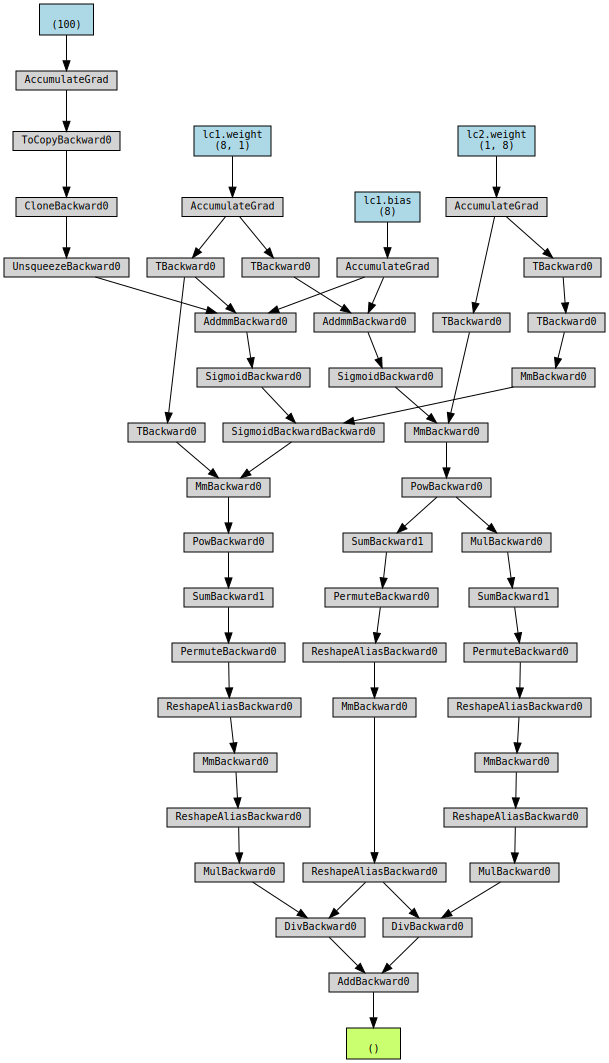

In [13]:
# Imports
from torchviz import make_dot 

make_dot(loss0, params=dict(list(net.named_parameters())))